# Roads and Buildings Segmentation - Machine Learning Challenge

The task is to build a model for a segmentation task. The [dataset](https://zenodo.org/record/1154821/) used is about *Learning Aerial Image Segmentation From Online Maps*

In [0]:
 # Download an unzip the dataset first 
!wget https://zenodo.org/record/1154821/files/berlin.zip
!unzip berlin.zip

In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import random
import matplotlib.pyplot as plt
from matplotlib import image
import albumentations as A

import tensorflow as tf
from tensorflow import keras
import segmentation_models as sm

Using TensorFlow backend.


Segmentation Models: using `keras` framework.


## Exploration of the dataset

Visualize key statistics about the images and masks and show us that you understand the underlying problem. 

(2453, 2611, 3)


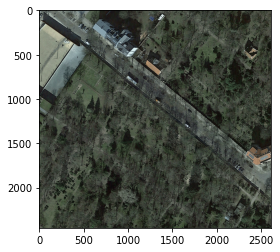

(2453, 2611, 3)


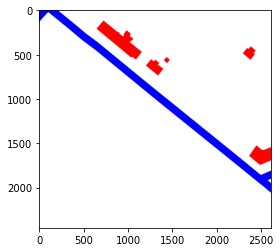

In [2]:
# Read Image
image_path = 'dataset/Berlin/berlin38_image.png'
image = plt.imread(image_path, 1)
print(image.shape)
  
# Output Image 
plt.imshow(image)
plt.show()

mask_path = 'dataset/Berlin/berlin38_labels.png'
mask = plt.imread(mask_path, 1)
print(mask.shape)
  
# Output Image 
plt.imshow(mask)
plt.show()

In [3]:
def overlay(image_path, mask_path, alpha=.5):
    image = cv2.imread(image_path, 0)
    plt.imshow(image, cmap='gray', vmin=0, vmax=255)

    mask = cv2.imread(mask_path, 1)
    rgba = cv2.cvtColor(mask, cv2.COLOR_RGB2RGBA)

    rgba = np.array(rgba)

    for i in range(rgba.shape[0]):
        for j in range(rgba.shape[1]):
            if rgba[i,j,:3].dot([1,1,1]) == 255*3:
                rgba[i,j,3] = 0
            elif rgba[i,j,0] == 255 and rgba[i,j,1] == 0 and rgba[i,j,2] == 0:
                rgba[i,j,0], rgba[i,j,1], rgba[i,j,2] = 0, 0, np.int8(255*alpha)
            elif rgba[i,j,0] == 0 and rgba[i,j,1] == 0 and rgba[i,j,2] == 255:
                rgba[i,j,0], rgba[i,j,1], rgba[i,j,2] = np.int8(255*alpha), 0, 0

    plt.imshow(rgba)
    plt.show()

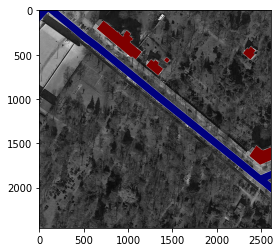

In [4]:
overlay(image_path, mask_path, alpha=.5)

## Train a segmentation model
Train a segmentation model to segment buildings and roads from the dataset.

The pipeline should:

- Ensure suitable splitting of the dataset and validation during training
- Give a short explanation of your model architecture choice 
- Explain the intuition behind your hyperparameter and data augmentation choices
- Visualize your model training statistics. Your are free to use Tensorboard or create charts with matplotlib.

### UNet

The UNet architecture contains two paths. The first one is the encoder which is used to capture the context in the image. The encoder consists of repeated application of convolutions, each followed by a rectified linear unit (ReLU) and a max pooling operation. The second path is the decoder which is used to enable precise localization using transposed convolutions. Thus, the UNet is an end-to-end fully convolutional network (FCN). According to the literature, the UNet architecture has contributed significantly in the Image Segmentation research. Thus, I consider that UNet is a good choice for this particular problem.

The ResNet101 was chosen as backbone because it performed better compared to the other choices that were tested (VGG16, VGG19, DenseNet121, InceptionResnetv2, EfficientNetb3 and EfficientNetb4.

### Hyperparameters and data augmentations

Unfortunately, I didn't have enough time to experiment with the hyperparameters. Most of them were set to default values or were chosen according to the related literature.

As regards the augmentations, a variety of augmentations were applied to the training set, but unfortunately there was not enough time to experiment and make a better choice.

### Prepare data and set datapaths

In [5]:
# Seperate images and labels into training, validation and test sets
def prepare_data(ids, data_path, img_path, lbl_path, splits=25):   
    for id_name in ids:
        image_path = os.path.join(data_path, id_name) + "_image.png"
        image = cv2.imread(image_path, 1)
        image_path = os.path.join(data_path + img_path, "image_" + id_name) + ".png"
        cv2.imwrite(image_path, image)
        
        label_path = os.path.join(data_path, id_name) + "_labels.png"
        label = cv2.imread(label_path, 1)
        label_path = os.path.join(data_path + lbl_path, "label_" + id_name) + ".png"
        cv2.imwrite(label_path, label)   

# Set Datapaths
data_dir = "dataset/Berlin/"

img_dir = 'Train_img'
img_path = os.path.join(data_dir, img_dir) 
os.mkdir(img_path)
lab_dir = 'Train_lbl'
lab_path = os.path.join(data_dir, lab_dir) 
os.mkdir(lab_path)

img_dir = 'Val_img'
img_path = os.path.join(data_dir, img_dir) 
os.mkdir(img_path)
lab_dir = 'Val_lbl'
lab_path = os.path.join(data_dir, lab_dir) 
os.mkdir(lab_path)

img_dir = 'Test_img'
img_path = os.path.join(data_dir, img_dir) 
os.mkdir(img_path)
lab_dir = 'Test_lbl'
lab_path = os.path.join(data_dir, lab_dir) 
os.mkdir(lab_path)

# Determine filenames
file_names = set([f.split('_')[0] for f in os.listdir(data_dir) if os.path.isfile(os.path.join(data_dir, f))])
file_names = list(file_names)

# Split Dataset
print("Dividing Data to Test Dataset...")
prepare_data(file_names[:40], data_dir, 'Test_img', 'Test_lbl')
print("Dividing Data to Validation Dataset...")
prepare_data(file_names[40:60], data_dir, 'Val_img', 'Val_lbl')
print("Dividing Data to Train Dataset...")
prepare_data(file_names[60:], data_dir, 'Train_img', 'Train_lbl')

# Set train, validation and test directories
data_dir = "dataset/Berlin/"
x_train_dir = os.path.join(data_dir, 'Train_img')
y_train_dir = os.path.join(data_dir, 'Train_lbl')

x_valid_dir = os.path.join(data_dir, 'Val_img')
y_valid_dir = os.path.join(data_dir, 'Val_lbl')

x_test_dir = os.path.join(data_dir, 'Test_img')
y_test_dir = os.path.join(data_dir, 'Test_lbl')

### DataGenerator and utility functions

In [6]:
# helper function for data visualization
def visualize(**images):
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

    
# helper function for data visualization    
def denormalize(x):
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x
    

# classes for data loading and preprocessing
class Dataset:
    """
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (dict): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
        preprocessing (albumentations.Compose): data preprocessing 
    """
    
    CLASSES = {'road':29, 'building':76}
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        ids = [id.split('_')[1] for id in self.ids]
        self.images = [os.path.join(images_dir, "image_" + image_id) for image_id in ids]
        self.masks = [os.path.join(masks_dir, "label_" +  image_id) for image_id in ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES[c] for c in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks[i], 0)
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]        
        mask = np.stack(masks, axis=-1).astype('float')
        
        # add background if mask is not binary
        if mask.shape[-1] != 1:
            background = 1 - mask.sum(axis=-1, keepdims=True)
            mask = np.concatenate((mask, background), axis=-1)
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)
    
    
class DataGenerator(keras.utils.Sequence):
    """
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))
        self.on_epoch_end()

        
    def __getitem__(self, i):       
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        return batch
    
    
    def __len__(self):
        return len(self.indexes) // self.batch_size
    
    
    def on_epoch_end(self):
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

# Visualize Image and Masks 

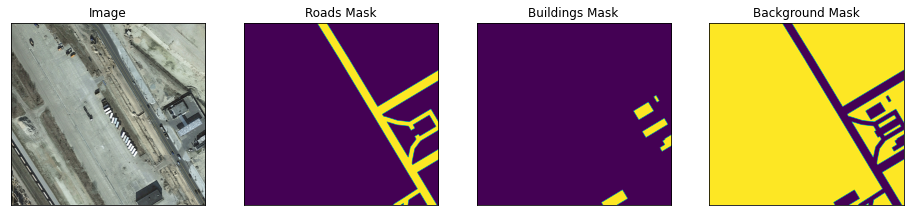

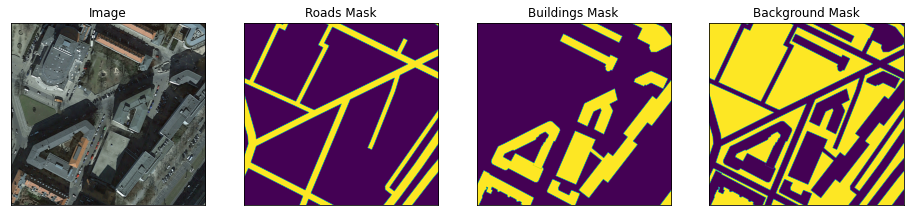

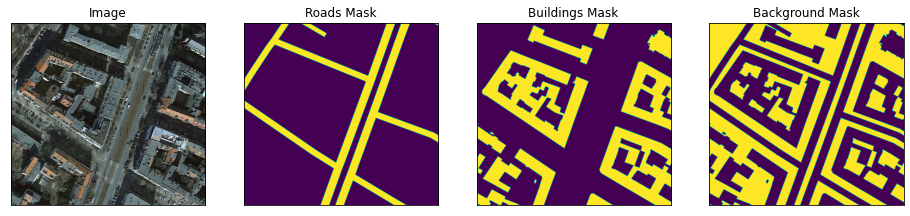

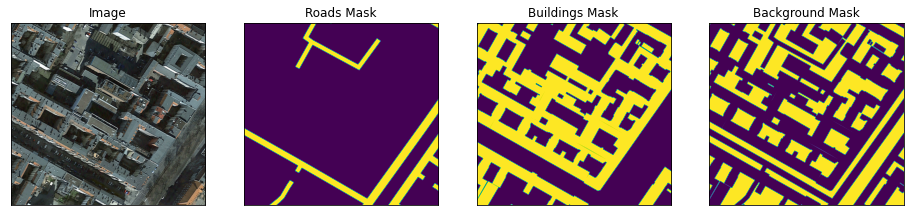

In [7]:
# Have a look at the dataset
dataset = Dataset(x_train_dir, y_train_dir, classes=['road', 'building'])
random_samples = [random.randint(0,len(dataset)) for _ in range(4)]

for r in random_samples:
    image, mask = dataset[r] # get some sample
    visualize(
        image=image, 
        roads_mask=mask[..., 0].squeeze(),
        buildings_mask=mask[..., 1].squeeze(),
        background_mask=mask[..., 2].squeeze(),
    )

### Augmentations

Since the number of available data is very small, a good way to reduce the model variance is to use data augmentation methods.The Albumentations library was used to perform several different augmentations:

    horizontal flip
    vertical flip
    affine transforms
    perspective transforms
    brightness/contrast/colors manipulations
    image bluring and sharpening
    gaussian noise
    random crops

In [8]:
def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

def get_training_augmentation():
    train_transform = [
        
        A.Resize(height=480, width=480, always_apply=True),

        A.HorizontalFlip(p=0.5),
        
        A.VerticalFlip(p=0.5),

        A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        A.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        A.RandomCrop(height=320, width=320, always_apply=True),

        A.IAAAdditiveGaussianNoise(p=0.2),
        A.IAAPerspective(p=0.5),

        A.OneOf(
            [
                A.CLAHE(p=1),
                A.RandomBrightness(p=1),
                A.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.IAASharpen(p=1),
                A.Blur(blur_limit=3, p=1),
                A.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.RandomContrast(p=1),
                A.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
        A.Lambda(mask=round_clip_0_1)
    ]
    return A.Compose(train_transform)

def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    valid_transform = [
        A.Resize(height=480, width=480, always_apply=True)
    ]
    return A.Compose(valid_transform)


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        A.Lambda(image=preprocessing_fn),
    ]
    return A.Compose(_transform)

def reverse_resize_augmentation(h, w):
    valid_transform = [
        A.Resize(height=h, width=w, always_apply=True)
    ]
    return A.Compose(valid_transform)

# Visualize Augmentations

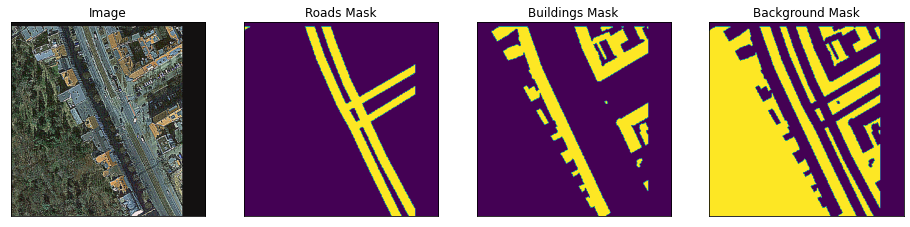

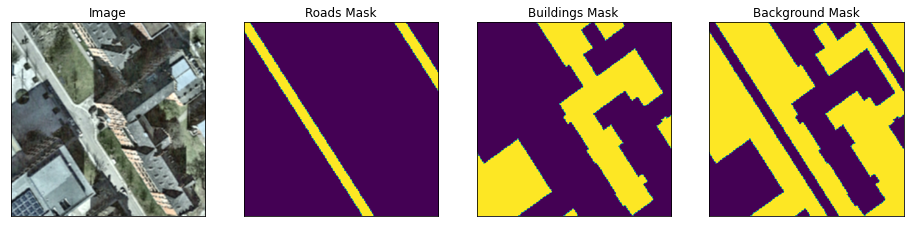

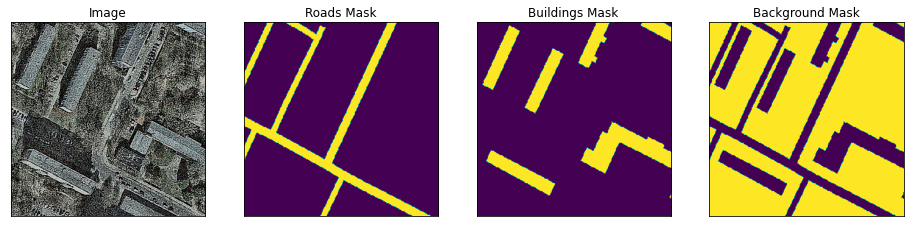

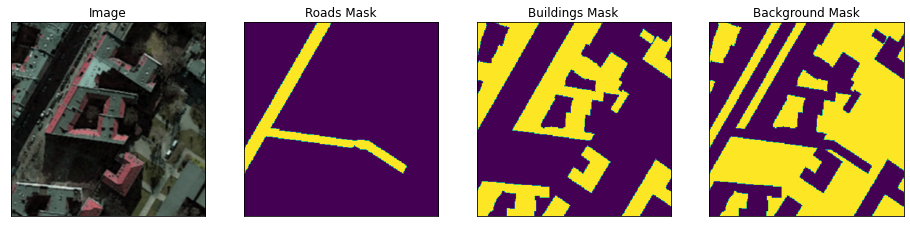

In [9]:
# Have a look at the augmented dataset
dataset = Dataset(x_train_dir, y_train_dir, classes=['road', 'building'], augmentation=get_training_augmentation())

random_samples = [random.randint(0,len(dataset)) for _ in range(4)]

for r in random_samples:
    image, mask = dataset[r] # get some sample
    visualize(
        image=image, 
        roads_mask=mask[..., 0].squeeze(),
        buildings_mask=mask[..., 1].squeeze(),
        background_mask=mask[..., 2].squeeze(),
    )

# Segmentation model training

In [29]:
BACKBONE = 'resnet101'
BATCH_SIZE = 8
CLASSES = ['road', 'building']
EPOCHS = 150

preprocess_input = sm.get_preprocessing(BACKBONE)

# define network parameters
n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)
activation = 'sigmoid' if n_classes == 1 else 'softmax'

#create model
model = sm.Unet(BACKBONE, classes=n_classes, activation=activation, encoder_weights='imagenet')

# define optomizer
optim = keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)

jaccard_loss = sm.losses.JaccardLoss()
crossentropy = sm.losses.BinaryCELoss() if n_classes == 1 else sm.losses.CategoricalCELoss()
total_loss = crossentropy + jaccard_loss

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)

# Dataset for train images
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    classes=CLASSES, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

# Dataset for validation images
valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

train_datagen = DataGenerator(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_datagen = DataGenerator(valid_dataset, batch_size=1, shuffle=False)

# check shapes for errors
assert train_datagen[0][0].shape == (BATCH_SIZE, 320, 320, 3)
assert train_datagen[0][1].shape == (BATCH_SIZE, 320, 320, n_classes)

# Train Model

In [30]:
# train model
history = model.fit_generator(
    train_datagen, 
    steps_per_epoch=len(train_datagen), 
    epochs=EPOCHS, 
    validation_data=valid_datagen,
    validation_steps=len(valid_datagen),
)

Epoch 1/150
17/17 [==============================] - 47s 3s/step - loss: 1.1738 - iou_score: 0.1247 - f1-score: 0.2161 - val_loss: 1.1685 - val_iou_score: 0.0167 - val_f1-score: 0.0167
Epoch 2/150
17/17 [==============================] - 39s 2s/step - loss: 1.0694 - iou_score: 0.1980 - f1-score: 0.3084 - val_loss: 1.1439 - val_iou_score: 0.0500 - val_f1-score: 0.0762
Epoch 3/150
17/17 [==============================] - 41s 2s/step - loss: 0.9881 - iou_score: 0.2783 - f1-score: 0.4050 - val_loss: 1.1435 - val_iou_score: 0.0419 - val_f1-score: 0.0631
Epoch 4/150
17/17 [==============================] - 41s 2s/step - loss: 0.9411 - iou_score: 0.3466 - f1-score: 0.4895 - val_loss: 1.1144 - val_iou_score: 0.1345 - val_f1-score: 0.2135
Epoch 5/150
17/17 [==============================] - 41s 2s/step - loss: 0.8901 - iou_score: 0.3918 - f1-score: 0.5354 - val_loss: 1.0721 - val_iou_score: 0.1769 - val_f1-score: 0.2773
Epoch 6/150
17/17 [==============================] - 41s 2s/step - loss: 0.

17/17 [==============================] - 41s 2s/step - loss: 0.4353 - iou_score: 0.7035 - f1-score: 0.8243 - val_loss: 0.6679 - val_iou_score: 0.6256 - val_f1-score: 0.7549
Epoch 90/150
17/17 [==============================] - 41s 2s/step - loss: 0.4424 - iou_score: 0.7003 - f1-score: 0.8221 - val_loss: 0.6162 - val_iou_score: 0.6267 - val_f1-score: 0.7532
Epoch 91/150
17/17 [==============================] - 41s 2s/step - loss: 0.4381 - iou_score: 0.7048 - f1-score: 0.8253 - val_loss: 0.6394 - val_iou_score: 0.6266 - val_f1-score: 0.7517
Epoch 92/150
17/17 [==============================] - 41s 2s/step - loss: 0.4226 - iou_score: 0.7165 - f1-score: 0.8324 - val_loss: 0.6315 - val_iou_score: 0.6312 - val_f1-score: 0.7569
Epoch 93/150
17/17 [==============================] - 41s 2s/step - loss: 0.4310 - iou_score: 0.7085 - f1-score: 0.8279 - val_loss: 0.6333 - val_iou_score: 0.6303 - val_f1-score: 0.7569
Epoch 94/150
17/17 [==============================] - 41s 2s/step - loss: 0.4307 - 

Epoch 133/150
17/17 [==============================] - 42s 2s/step - loss: 0.3853 - iou_score: 0.7378 - f1-score: 0.8477 - val_loss: 0.6757 - val_iou_score: 0.6304 - val_f1-score: 0.7546
Epoch 134/150
17/17 [==============================] - 41s 2s/step - loss: 0.3731 - iou_score: 0.7454 - f1-score: 0.8529 - val_loss: 0.6470 - val_iou_score: 0.6318 - val_f1-score: 0.7563
Epoch 135/150
17/17 [==============================] - 42s 2s/step - loss: 0.3815 - iou_score: 0.7407 - f1-score: 0.8492 - val_loss: 0.6562 - val_iou_score: 0.6342 - val_f1-score: 0.7601
Epoch 136/150
17/17 [==============================] - 42s 2s/step - loss: 0.3915 - iou_score: 0.7303 - f1-score: 0.8422 - val_loss: 0.6388 - val_iou_score: 0.6317 - val_f1-score: 0.7581
Epoch 137/150
17/17 [==============================] - 42s 2s/step - loss: 0.3742 - iou_score: 0.7421 - f1-score: 0.8505 - val_loss: 0.6925 - val_iou_score: 0.6326 - val_f1-score: 0.7573
Epoch 138/150
17/17 [==============================] - 41s 2s/ste

# Visualize IOU score and Loss

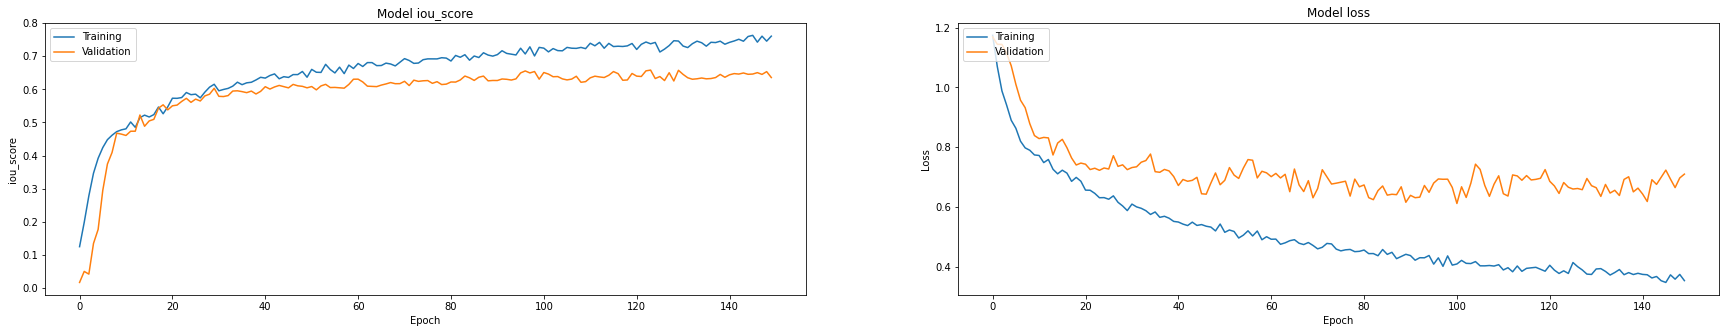

In [31]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

In [36]:
# load weights
# model.load_weights('UNet_resnet101.h5')

# save weights
model.save_weights('UNet_resnet101.h5')

## Create an inference function 
Create a function which is able to make predictions on new images. The format has to be identical to the original masks from the training data: 

  - Red color for buildings 
  - Blue color for streets
  - White color for everything else

# Helper functions

In [32]:
def select_channel(img):
    idz = np.argmax(img, axis=2)
    mask = np.zeros(img.shape)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            mask[i,j,idz[i,j]] = 1
    return mask

def label_colors(img):
    for m in range(img.shape[0]):
        for n in range(img.shape[1]):
            if img[m,n,0] == 0 and img[m,n,1] == 0 and img[m,n,2] == 1:
                img[m,n,0], img[m,n,1], img[m,n,2] = 1, 1, 1 
            elif img[m,n,0] == 0 and img[m,n,1] == 1 and img[m,n,2] == 0:
                img[m,n,0], img[m,n,1], img[m,n,2] = 1, 0, 0
            else:
                img[m,n,0], img[m,n,1], img[m,n,2] = 0, 0, 1
    return img

def reverse_image_size(h, w, image):
    reverseResize = reverse_resize_augmentation(h, w)
    data = {"image": image}
    reversed_img = reverseResize(**data)
    image = reversed_img["image"]
    return image

def rb2br(img):
    for m in range(img.shape[0]):
        for n in range(img.shape[1]):
            if img[m,n,0] == 1 and img[m,n,1] == 0 and img[m,n,2] == 0:
                img[m,n,0], img[m,n,1], img[m,n,2] = 0, 0, 1
            elif img[m,n,0] == 0 and img[m,n,1] == 0 and img[m,n,2] == 1:
                img[m,n,0], img[m,n,1], img[m,n,2] = 1, 0, 0
    return img

Loss: 0.48055
mean iou_score: 0.63299
mean f1-score: 0.75532


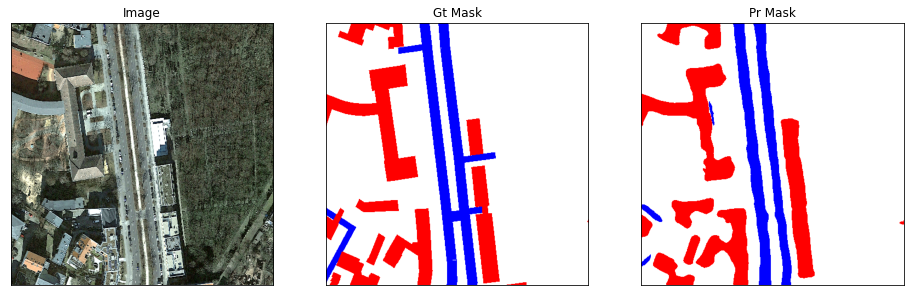

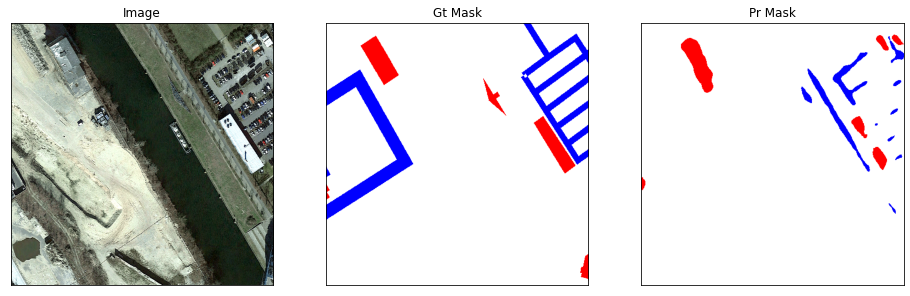

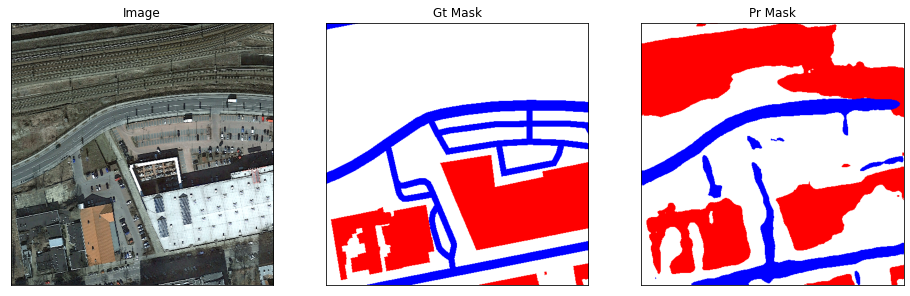

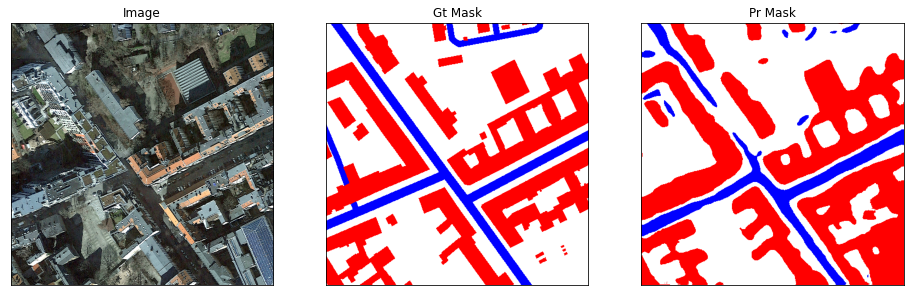

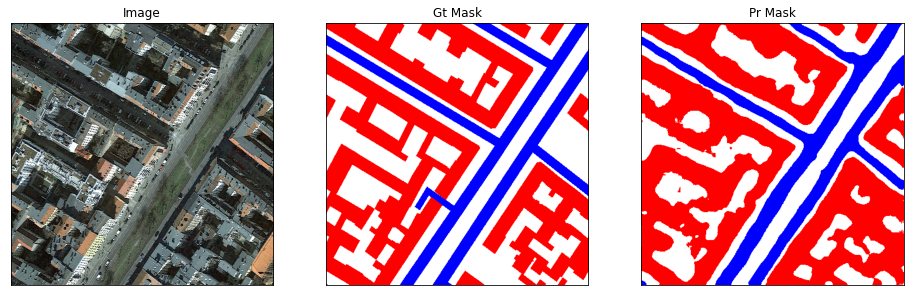

In [38]:
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

test_datagen = DataGenerator(test_dataset, batch_size=1, shuffle=False)

scores = model.evaluate_generator(test_datagen)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

# Show some random predictions from the test dataset
n = 5
ids = np.random.choice(np.arange(len(test_dataset)), size=n)

for i in ids:
    
    image, gt_mask = test_dataset[i]
    image = np.expand_dims(image, axis=0)
    pr_mask = model.predict(image)
    
    gt_mask=gt_mask.squeeze()
    pr_mask=pr_mask.squeeze()
    
    gt_mask = label_colors(gt_mask)
    pr_mask = select_channel(pr_mask)
    pr_mask = label_colors(pr_mask)   
    
    visualize(
        image=denormalize(image.squeeze()),
        gt_mask=gt_mask.squeeze(),
        pr_mask=pr_mask.squeeze(),
    )

    
image_path = 'dataset/Berlin/berlin1_image.png'
mask_path = 'dataset/Berlin/berlin1_labels.png'
out_file = 'dataset/Berlin/berlin1_predictions.png'

model_checkpoint = 'UNet_resnet101.h5'
    
def predict(model_checkpoint, image_path, out_file, preprocess_input):
    
    BACKBONE = 'resnet101'
    CLASSES = ['road', 'building']
    preprocess_input = sm.get_preprocessing(BACKBONE)  
    # define network parameters
    n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)
    activation = 'sigmoid' if n_classes == 1 else 'softmax'
    #create model
    model = sm.Unet(BACKBONE, classes=n_classes, activation=activation, encoder_weights='imagenet')
    # define optomizer
    optim = keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)
    jaccard_loss = sm.losses.JaccardLoss()
    crossentropy = sm.losses.BinaryCELoss() if n_classes == 1 else sm.losses.CategoricalCELoss()
    total_loss = crossentropy + jaccard_loss
    metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]
    # compile keras model with defined optimozer, loss and metrics
    model.compile(optim, total_loss, metrics)
    model.load_weights(model_checkpoint)   
    
    image = cv2.imread(image_path, 1)
    h, w = image.shape[:2]
    resizeImage = get_validation_augmentation()
    data = {"image": image}
    resized = resizeImage(**data)
    image= resized["image"]  
    preprocImage = get_preprocessing(preprocess_input)
    data = {"image": image}
    resized = preprocImage(**data)
    image= resized["image"]
    image = np.expand_dims(image, axis=0)

    pr_mask = model.predict(image)
    pr_mask=pr_mask.squeeze()
    
    pr_mask = select_channel(pr_mask)
    pr_mask = label_colors(pr_mask)
    
    pr_mask = rb2br(pr_mask)
    
    pr_mask = np.int16(255 * pr_mask)
    pr_mask = reverse_image_size(h, w, pr_mask)
        
    cv2.imwrite(out_file, pr_mask)

    
predict(model_checkpoint, image_path, out_file, preprocess_input)

## Summarize the findings

### Rate overall Results
Overall results are relatively good. The mean IOU is greater than 0.6. In the visualization, we can see that the model can identify correctly big parts of the picture.

### Mistakes
The model is unable to identify small roads. Moreover, the model cannot identify the exact shape of buildings (building edges are curvy).

### Improvements
    Calibrate hyperparameter
    Examine more backbones
    Experiment with augmentations
    Train with cropped images of the original size instead of resizing and predict the full image in parts